
# Hybrid GNN + 3D Distances + Transformer Attention Block + RDKit Descriptors

Our 3D-aware graph neural network architecture takes as input atom features, bond types, and crucial edge distance information derived from the 3D molecular coordinates. The model begins with independent Atom and Bond Encoders to generate initial embeddings for the atoms and bonds, respectively. Notably, the Bond Encoder is augmented to directly incorporate the Euclidean distance between bonded atoms as an additional feature. These initial embeddings are then processed through two layers of Graph Isomorphism Network with Edge features (GINEConv), where the edge distance feature is explicitly utilized during message passing, allowing the model to learn relationships influenced by spatial proximity. To capture global interactions within the molecule, we employ a Self-Attention block. Following the GNN and attention layers, a CLS token pooling strategy is used to obtain a fixed-size representation of the entire molecular graph. This global graph embedding is then concatenated with a set of six 1D global molecular descriptors calculated using RDKit. Finally, the combined feature vector is fed into a multi-layer perceptron (MLP) prediction head to output the predicted HOMO-LUMO gap.

The implementation of this 3D-aware GNN model involved several key steps. First, 3D molecular structures were loaded from SDF files using RDKit. Simultaneously, the 2D graph representations and the corresponding dataset splits were loaded using the PyG PCQM4Mv2 Dataset. Additionally, SMILES strings for all molecules were loaded to compute a set of six global molecular descriptors (molecular weight, number of rotatable bonds, topological polar surface area, number of hydrogen acceptors, number of hydrogen donors, and ring count) using RDKit. To enrich the atom-level information beyond the standard atomic number, a custom atom feature extractor was implemented to include features like formal charge, aromaticity, hybridization, ring membership, and the number of attached hydrogens. These extra atom features were then projected and combined with the output of the standard AtomEncoder. Crucially, a custom `create_data_object` function was developed to process each molecule: it extracts 2D graph information, retrieves 3D coordinates, calculates Euclidean distances between bonded atoms, incorporates the custom atom features, and constructs a PyG `Data` object that explicitly includes the edge distances as part of the edge attributes. These enhanced `Data` objects, now incorporating 3D information, were then chunked and saved to disk for efficient loading during training using an LMDB database. The training process utilized optimized hyperparameters identified from prior experiments, the AdamW optimizer with a cosine scheduler and warmup, mixed-precision training with gradient scaling, and early stopping based on the validation loss.


In [1]:
# ════════════════════════════════════════════════════════════════
# 7. model – geometry used only if present
# ════════════════════════════════════════════════════════════════
from torch_geometric.nn import GINEConv
from torch_geometric.utils import to_dense_batch
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
import torch 
import torch.nn as nn
import random 

class ExtendedAtomEncoder(nn.Module):
    def __init__(self, gnn_dim, extra_atom_dim):
        super().__init__()
        self.atom_encoder = AtomEncoder(emb_dim=gnn_dim)
        self.extra_proj = nn.Linear(extra_atom_dim, gnn_dim)
        self.output_proj = nn.Linear(gnn_dim * 2, gnn_dim)  # Combine encoded + extra info

    def forward(self, x, extra_atom_features):
        """
        x: [num_atoms, atom_input_dim] -> original atom input (atomic number idx)
        extra_atom_features: [num_atoms, extra_atom_dim] -> handcrafted features
        """
        atom_emb = self.atom_encoder(x)            # [num_atoms, gnn_dim]
        extra_emb = self.extra_proj(extra_atom_features.float())  # [num_atoms, gnn_dim]
        extra_emb = torch.nan_to_num(extra_emb, nan=0.0, posinf=0.0, neginf=0.0)
        combined = torch.cat([atom_emb, extra_emb], dim=-1)  # [num_atoms, gnn_dim*2]
        output = self.output_proj(combined)                  # [num_atoms, gnn_dim]
        return output
    
class BondEncoderWithDist(nn.Module):
    """
    First three cols = OGB categorical bond features (int)
    Remaining K cols = continuous geometry embedding (float)
    """
    def __init__(self, emb_dim: int, n_rbf: int = 32):
        super().__init__()
        from ogb.graphproppred.mol_encoder import BondEncoder
        self.cat_enc  = BondEncoder(emb_dim)                    # (E,3)  → (E,D)
        self.dist_mlp = nn.Sequential(                          # (E,K)  → (E,D)
            nn.Linear(n_rbf, emb_dim), nn.SiLU(),
            nn.Linear(emb_dim, emb_dim))

    def forward(self, edge_attr: torch.Tensor) -> torch.Tensor:
        cat  = self.cat_enc(edge_attr[:, :3].long())
        geo  = self.dist_mlp(edge_attr[:, 3:].float())
        return cat + geo
    
# ────────────────────────────────────────────────────────────────
# 8. edge & triplet up‑dates
# ────────────────────────────────────────────────────────────────
class PairWiseUpdate(nn.Module):
    """
    one liner edge updater e_ij ← f(e_ij , h_i , h_j)
    keeps the size (E, D) unchanged so batching still works
    """
    def __init__(self, dim):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(3*dim, dim), nn.SiLU(),
            nn.Linear(dim, dim))
    def forward(self, e, hi, hj):        # all (E, D)
        return self.f(torch.cat([e, hi, hj], -1))

from torch_scatter import scatter
import torch.nn.functional as F

class TripletBlock(nn.Module):
    def __init__(self, dim, num_samples=4):
        super().__init__()
        self.angle_mlp = nn.Sequential(
            nn.Linear(1, dim), nn.SiLU(), nn.Linear(dim, dim))
        self.num_samples = num_samples

    def forward(self, pos, edge_index, e):  # pos: (N,3), edge_index: (2,E), e: (E,D)
        device = pos.device
        src, dst = edge_index[0], edge_index[1]
        num_nodes = pos.size(0)

        # Build adjacency list
        adj = [[] for _ in range(num_nodes)]
        for i, j in zip(src.tolist(), dst.tolist()):
            adj[i].append(j)

        # Sample k for each edge (i, j)
        new_i, new_j, new_k, group_idx = [], [], [], []
        for idx, (i, j) in enumerate(zip(src.tolist(), dst.tolist())):
            neighbors = [k for k in adj[i] if k != j]
            if len(neighbors) == 0:
                continue
            ks = random.sample(neighbors, min(self.num_samples, len(neighbors)))
            for k in ks:
                new_i.append(i)
                new_j.append(j)
                new_k.append(k)
                group_idx.append(idx)  # for aggregation

        if len(new_i) == 0:
            return e  # no triplets found

        i = torch.tensor(new_i, device=device)
        j = torch.tensor(new_j, device=device)
        k = torch.tensor(new_k, device=device)
        group_idx = torch.tensor(group_idx, device=device)

        v1 = pos[i] - pos[j]
        v2 = pos[i] - pos[k]
        cos = (v1 * v2).sum(-1, keepdim=True) / (
            v1.norm(dim=-1, keepdim=True) * v2.norm(dim=-1, keepdim=True) + 1e-9)
        ang = torch.acos(torch.clamp(cos, -1 + 1e-6, 1 - 1e-6))  # (T, 1)
        gate = self.angle_mlp(ang)  # (T, D)

        # Aggregate angle gates over original edges
        angle_update = scatter(gate, group_idx, dim=0, dim_size=e.size(0), reduce='mean')
        return e + angle_update

: 

In [1]:
import lmdb, random, torch
from graphdata_lmdb import LMDBDataset          
import os

# ── create the loader first ───────────────────────────────────
DATA_ROOT = r"C:/Users/mattg/Downloads/HOMO-LUMO/data"
LMDB_PATH = os.path.join(DATA_ROOT, "processed_chunks", "pcqm4m_train3d_dist.lmdb")
RAND_SEED  = 0

# ── fetch every key once (fast – ~1 s for 3.3 M graphs) ────────────────
with lmdb.open(LMDB_PATH, readonly=True, lock=False, readahead=False) as env:
    with env.begin(buffers=True) as txn:
        all_ids = [int(k) for k, _ in txn.cursor()]
print(f"LMDB contains {len(all_ids):,} graphs")

# ── train/val split (10 %) ─────────────────────────────────────────────
random.seed(RAND_SEED)
val_k    = int(0.10 * len(all_ids))
valid_ids = random.sample(all_ids, k=val_k)
valid_ids_set = set(valid_ids)  # Convert to a set for faster lookups
train_ids = [i for i in all_ids if i not in valid_ids_set]

# ── DataLoaders (multiprocessing safe) ────────────────────────────────
from torch_geometric.loader import DataLoader

train_loader = DataLoader(LMDBDataset(train_ids, LMDB_PATH), batch_size=128, shuffle=True) 
valid_loader = DataLoader(LMDBDataset(valid_ids, LMDB_PATH), batch_size=128, shuffle=False) 

# quick smoke test
batch = next(iter(train_loader))
print("dist shape:", batch.dist[0].shape)

LMDB contains 0 graphs


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [3]:
import os
from pathlib import Path
import torch
import re

CKPT_DIR = Path("checkpoints")         
CKPT_DIR.mkdir(exist_ok=True)

def save_ckpt(tag, epoch, model, optimizer, scheduler, scaler, best_val, patience_ctr, train_hist, val_hist, keep_last=2, folder="checkpoints"):
    """
    Save `ckpt_{epoch:03d}.pt` and keep only the *latest* `keep_last`
    files with the given tag (e.g. tag = "runA").
    """
    os.makedirs(folder, exist_ok=True)
    fname = f"{folder}/{tag}_e{epoch:03d}.pt"
    torch.save({
        "epoch"   : epoch,
        "model"   : model.state_dict(),
        "optim"   : optimizer.state_dict(),
        "sched"   : scheduler.state_dict(),
        "scaler"  : scaler.state_dict(),
        "best_val": best_val,
        "patience": patience_ctr,
        "train_hist": train_hist,
        "val_hist": val_hist,
    }, fname)

    # ── garbage-collect older ckpts ─────────────────────────────
    ckpts = sorted(Path(folder).glob(f"{tag}_e*.pt"),
                   key=lambda p: int(re.search(r"e(\d+)", p.stem).group(1)))
    for p in ckpts[:-keep_last]:
        p.unlink(missing_ok=True)

def load_ckpt(path, model, optimizer, scheduler, scaler, map_location="cpu"):
    ckpt = torch.load(path, map_location=map_location)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optim"])
    scheduler.load_state_dict(ckpt["sched"])
    scaler.load_state_dict(ckpt["scaler"])
    return ckpt

What if you later need 3-D for the public test split?

Exactly the same idea:
---
test_ids   = split["test-dev"]          # or test-challenge

test_3d    = [(i, None) for i in test_ids]     # no SDF available

env = lmdb.open("pcqm4m_test3d.lmdb", map_size=...)

txn = env.begin(write=True)

for idx, _ in tqdm.tqdm(test_3d):

    smiles = smiles_ds[idx][0]

    mol    = make_conformer(smiles)           # ETKDG

    txn.put(str(idx).encode(), dump(pack(build_data(idx, mol))))
    
txn.commit(); env.close()
---
You can concatenate that LMDB with the existing one (or keep two separate databases and query the right one, up to you) – since the keys are the same indices everything stays consistent.

In [4]:
# ════════════════════════════════════════════════════════════════
# 12. TransformerEncoderLayerWithBias
# ════════════════════════════════════════════════════════════════
import torch
import torch.nn as nn
from torch.nn import TransformerEncoderLayer
import torch.nn.functional as F
import torch
from torch_geometric.utils import to_dense_batch, to_dense_adj
import torch
import torch.nn as nn
import torch.nn.functional as F
# ── helpers for robust training ─────────────────────────────────────────
def has_nan(t: torch.Tensor) -> bool:
    """True ⇢ tensor contains NaN or ±Inf (works on fp16/fp32)."""
    return torch.isfinite(t).logical_not().any().item()

@torch.no_grad()
def clip_grad_and_nan(parameters, max_norm: float = 5.0, eps: float = 1e-6):
    """
    • set grad-NaNs / Infs → 0  
    • global-norm clip (like torch.clip_grad_norm_)  
    """
    total_norm = torch.zeros(1, device=next(iter(parameters)).device)
    for p in parameters:
        if p.grad is None:            # skip leafs w/o grad
            continue
        # 1) kill NaN & Inf in this parameter’s grad
        bad_mask = torch.isfinite(p.grad).logical_not()
        if bad_mask.any():
            p.grad[bad_mask] = 0.0
        # 2) accumulate L2-norm² for global clip
        total_norm.add_(p.grad.norm(2).pow(2))
    total_norm = total_norm.sqrt()
    clip_coef  = max_norm / (total_norm + eps)
    if clip_coef < 1.0:
        for p in parameters:
            if p.grad is not None:
                p.grad.mul_(clip_coef)

def safe_optimizer_step(scaler, optimizer, model, max_norm: float = 5.0):
    """
    Replacement for the usual unscale → clip → step → update block.
    """
    scaler.unscale_(optimizer)                     # grads now fp32
    clip_grad_and_nan(model.parameters(), max_norm)
    scaler.step(optimizer)
    scaler.update()

class TransformerEncoderLayerWithBias(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1,
                 dim_feedforward=2048, activation="ReLU", batch_first=True):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
        self.d_model = d_model
        self.linear1  = nn.Linear(d_model, dim_feedforward)
        self.dropout  = nn.Dropout(dropout)
        self.linear2  = nn.Linear(dim_feedforward, d_model)
        self.norm1    = nn.LayerNorm(d_model)
        self.norm2    = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = F.relu if activation == "ReLU" else F.gelu
        self.nhead = nhead # keep for external checks

    def forward(self, src, src_key_padding_mask=None, attn_bias=None):
        B, L, _ = src.size()

        # ------------------------------------------------------------------
        # build attention mask
        # expected shape:  (B · nhead,  L,  L)
        # ------------------------------------------------------------------
        if attn_bias is not None:
            assert attn_bias.shape == (B, self.nhead, L, L), f"attn_bias must be (B,H,L,L), got {attn_bias.shape}"
            attn_mask = attn_bias.view(B * self.nhead, L, L)
        else:
            attn_mask = None

        # MultiheadAttention already projects & splits into heads internally
        attn_output, _ = self.self_attn(src, src, src, attn_mask=attn_mask, key_padding_mask=src_key_padding_mask) # attn_output: (B, L, D)
        src = self.norm1(src + self.dropout1(attn_output))
        ff  = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = self.norm2(src + self.dropout2(ff))
        return src

In [5]:
# ════════════════════════════════════════════════════════════════
# 14. final model  
# ════════════════════════════════════════════════════════════════
import copy
import torch
import torch.nn as nn
from torch.nn import TransformerEncoderLayer
from torch_geometric.utils import to_dense_batch

# Custom Transformer encoder wrapper that accepts attn_bias
class CustomTransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(encoder_layer.d_model)

    def forward(self, src, mask, attn_bias=None):
        for mod in self.layers:
            src = mod(src, src_key_padding_mask=mask, attn_bias=attn_bias)
        return self.norm(src)


class GNN_Transformer_Hybrid(nn.Module):
    def __init__(self, gnn_dim, rdkit_dim, hidden_dim, extra_atom_dim, num_transformer_layers=2, num_heads=8, dropout_rate=0.2, activation='GELU'):
        super().__init__()
        act_map = {'ReLU': nn.ReLU(), 'ELU': nn.ELU(), 'LeakyReLU': nn.LeakyReLU(), 'PReLU': nn.PReLU(), 'GELU': nn.GELU(), 'Swish': nn.SiLU()}
        act_fn = act_map[activation]
        self.gnn_dim = gnn_dim
        self.rdkit_dim = rdkit_dim
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads  

        # Atom and bond encoders
        self.atom_encoder = ExtendedAtomEncoder(gnn_dim, extra_atom_dim)
        self.bond_encoder = BondEncoderWithDist(gnn_dim, n_rbf=32)
        # in __init__
        self.cls_token = nn.Parameter(torch.zeros(1, gnn_dim))
        nn.init.normal_(self.cls_token, std=0.02)
        
        # message passing
        self.conv1 = GINEConv(nn.Sequential(nn.Linear(gnn_dim, gnn_dim), act_fn, nn.Linear(gnn_dim, gnn_dim)))
        self.edge_upd1 = PairWiseUpdate(gnn_dim)
        self.conv2 = GINEConv(nn.Sequential(nn.Linear(gnn_dim, gnn_dim), act_fn, nn.Linear(gnn_dim, gnn_dim)))
        self.edge_upd2 = PairWiseUpdate(gnn_dim)
        self.triplet   = TripletBlock(gnn_dim)

        # Custom Transformer encoder
        encoder_layer = TransformerEncoderLayerWithBias(d_model=gnn_dim,
                                                        nhead=num_heads,
                                                        batch_first=True,
                                                        dim_feedforward=gnn_dim * 4,
                                                        dropout=dropout_rate)
        self.transformer = CustomTransformerEncoder(encoder_layer, num_layers=num_transformer_layers)

        # Final prediction head
        self.mlp = nn.Sequential(nn.Linear(gnn_dim + rdkit_dim, hidden_dim), act_fn,
                                 nn.Dropout(dropout_rate),
                                 nn.Linear(hidden_dim, hidden_dim // 2), act_fn,
                                 nn.Dropout(dropout_rate),
                                 nn.Linear(hidden_dim // 2, 1))
    
    def forward(self, data):

        # 1) encoders 
        x = self.atom_encoder(data.x, data.extra_atom_feats)
        if has_nan(x):
            raise RuntimeError("NaN after atom_encoder")

        e   = self.bond_encoder(data.edge_attr)
        src, dst = data.edge_index

        for conv, upd in [(self.conv1, self.edge_upd1),
                        (self.conv2, self.edge_upd2)]:
            x = conv(x, data.edge_index, e)
            e = upd(e, x[src], x[dst])
            if data.has_xyz.any():
                e = self.triplet(data.pos, data.edge_index, e)
        if has_nan(x):
            raise RuntimeError("NaN after GINE")

        # ──────────────────────────────────────────────────────────
        # 2) pack graphs (+CLS)
        # ──────────────────────────────────────────────────────────
        B, parts, sizes = int(data.batch.max()) + 1, [], []
        for i in range(B):
            idx = (data.batch == i).nonzero(as_tuple=True)[0]
            xi  = x[idx]
            parts.append(torch.cat([xi, self.cls_token], 0))
            sizes.append(xi.size(0) + 1)

        all_feat = torch.cat(parts, 0)
        batch    = torch.repeat_interleave(
                        torch.arange(B, device=x.device),
                        torch.tensor(sizes, device=x.device))
        pad, mask = to_dense_batch(all_feat, batch)          # (B,L,D)
        max_nodes = pad.size(1)

        # ──────────────────────────────────────────────────────────
        # 3) attention-bias   (fp32,   B × H × L × L)
        # ──────────────────────────────────────────────────────────
        bias_stack = []
        dist_iter  = iter(data.dist)                         # (MAX_NODES, MAX_NODES)

        for i in range(B):
            dist = next(dist_iter).to(x.device)              # uint8 → device
            n    = sizes[i] - 1                              # real atoms  (–CLS)

            # safety-net ① — empty graph (rare, but possible with data errors)
            if n == 0:
                bias_stack.append(torch.zeros(max_nodes, max_nodes,
                                            dtype=torch.float32,
                                            device=x.device))
                continue

            # crop and negate distances, then CLAMP
            local = -dist[:n, :n].float()                    # 0 on diag, –d elsewhere
            tmp   = torch.zeros(max_nodes, max_nodes,
                                dtype=torch.float32,
                                device=x.device)
            tmp[:n, :n] = local.clamp(min=-5.0, max=0.0)     # safety-net ②
            bias_stack.append(tmp)

        attn_bias = torch.stack(bias_stack, 0)               # (B,L,L)
        attn_bias = attn_bias.unsqueeze(1)                   # (B,1,L,L)
        attn_bias = attn_bias.repeat(1, self.num_heads, 1, 1)# (B,H,L,L)

        if has_nan(attn_bias):
            raise RuntimeError("NaN in attention-bias")

        # ──────────────────────────────────────────────────────────
        # 4) Transformer  (fp32 everywhere → no dtype warning)
        # ──────────────────────────────────────────────────────────
        pad_fp32      = pad.float()                   # (B,L,D)  fp32 -- safer numerics
        valid_mask    = mask                          # (B,L)    bool   True==real node
        key_padding   = (~valid_mask).float()         # (B,L)    fp32   1==PAD, 0==keep

        # forward through the stacked encoder layers
        pad_out = self.transformer(pad_fp32,           # src
                                key_padding,        # src_key_padding_mask (fp32)
                                attn_bias)          # attn_bias (fp32, B×H×L×L)

        # last-resort sanitiser – replace any NaNs/Infs that still slip through
        if has_nan(pad_out):
            pad_out = torch.nan_to_num(pad_out, nan=0.0, posinf=0.0, neginf=0.0)

        # CLS token is always the last *real* position in each sequence
        cls_idx  = valid_mask.sum(1) - 1              # (B,)
        cls_out  = pad_out[torch.arange(B, device=x.device), cls_idx]

        out = torch.cat([cls_out, data.rdkit_feats.float()], dim=1)
        return self.mlp(out)


# preprocessing function

1. Load each molecule from the dataset

2. Extract 3D coordinates (optional, later for distance edges)

3. Extract atom features (formal charge, aromaticity, etc.)

4. Return a fully enhanced torch_geometric.data.Data object

# Dataloader

LMDB (Lightning Memory-Mapped Database) is a highly efficient, ordered key-value store that leverages memory mapping for exceptional read performance. Instead of traditional disk I/O, LMDB directly maps the database file into the virtual address space of your process, eliminating the overhead of system calls and data copying. This memory-mapped approach allows for zero-copy reads, making data access feel as fast as accessing in-memory data while retaining disk-based persistence and data safety. Keys within an LMDB database are always lexicographically sorted, which can be advantageous for range queries. It supports multiple concurrent readers without blocking and a single, consistent writer (MVCC), making it robust for various applications requiring fast and reliable data access with a small footprint.

To employ LMDB for efficient handling of 3D molecular graph data, the process involves a distinct writing and reading phase. Initially, pre-processed PyTorch Geometric (Data) objects, representing individual molecules, are loaded from chunk files (.pt files). Each Data object, containing graph features like node features (x), edge indices (edge_index), edge attributes (edge_attr), and 3D coordinates (pos), is converted into a lean Python dictionary using the pack function. This step also includes downcasting the numerical data types of the tensors to reduce memory usage. Subsequently, this dictionary is serialized using Python's pickle library and then compressed with gzip via the gz_pickle function, yielding a compact byte string. This compressed representation of each molecular graph is then stored in an LMDB database (pcqm4_3d.lmdb) using a unique integer identifier (gidx) as the key.

For accessing this data during model training or evaluation, a custom PyTorch Dataset class, LeanLMDBDataset, is created. This dataset takes a list of indices and the path to the LMDB database. When a specific molecular graph is requested by the DataLoader (through the __getitem__ method using an index), the LeanLMDBDataset opens a read-only transaction with the LMDB environment. It then retrieves the corresponding compressed byte string using the provided index as the key. The gz_unpickle function decompresses and deserializes this byte string back into the lean dictionary. Finally, the dict_to_data function reconstructs the PyTorch Geometric Data object from this dictionary, ensuring the tensors are converted back to the appropriate PyTorch tensors. This on-demand retrieval mechanism avoids loading the entire dataset into memory, enabling the processing of large molecular datasets one graph at a time or in mini-batches managed by the DataLoader.

Right now your graph edges have only:

Bond types (edge_attr)

But we want to add distance information to edge_attr, so your GNN knows how far apart two atoms are in 3D space.

This massively improves model accuracy for tasks like HOMO-LUMO gap prediction!

Step | Action
1 | For each molecule, extract 3D coordinates from the SDF
2 | For each bond (edge), calculate the 3D distance between the two atoms
3 | Concatenate or add this distance as a new dimension in edge_attr
4 | Train model with this upgraded information

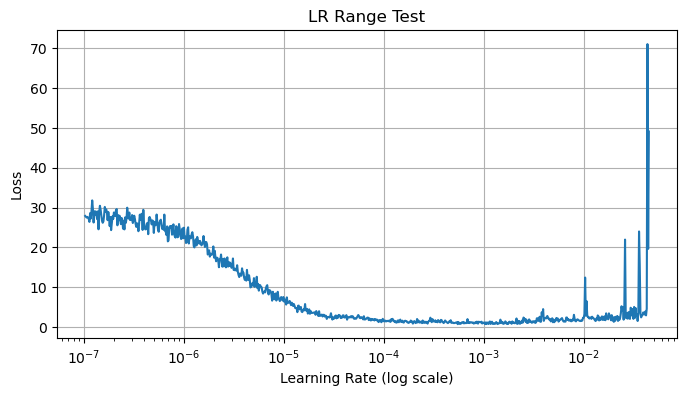

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

class LRFinder:
    def __init__(self, model, optimizer, device, criterion=F.mse_loss):
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.criterion = criterion
        self.history = []

    def range_test(self, train_loader, start_lr=1e-7, end_lr=1.0, num_iter=100):
        self.model.train()
        lr_lambda = lambda x: np.exp(x * np.log(end_lr / start_lr) / num_iter)
        scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lr_lambda)

        losses = []
        lrs = []
        best_loss = float('inf')

        iter_loader = iter(train_loader)
        
        for i in range(num_iter):
            try:
                batch = next(iter_loader)
            except StopIteration:
                iter_loader = iter(train_loader)
                batch = next(iter_loader)

            batch = batch.to(self.device)
            self.optimizer.zero_grad()

            output = self.model(batch)
            loss = self.criterion(output, batch.y.view(-1, 1))

            loss.backward()
            self.optimizer.step()
            scheduler.step()

            lr = self.optimizer.param_groups[0]["lr"]
            if has_nan(loss) or torch.isinf(loss):
                print(f"NaN at iter {i}, LR={lr:.2e}")
                break
            losses.append(loss.item())
            lrs.append(lr)

            # Stop if loss explodes
            if loss.item() > 100 * best_loss:
                break
            if loss.item() < best_loss:
                best_loss = loss.item()

        self.history = (lrs, losses)

    def plot(self, skip_start=1, skip_end=1):
        lrs, losses = self.history
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
        plt.figure(figsize=(8, 4))
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel("Learning Rate (log scale)")
        plt.ylabel("Loss")
        plt.title("LR Range Test")
        plt.grid(True)
        plt.show()

# Clone and reinit model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GNN_Transformer_Hybrid(gnn_dim=512,
                               rdkit_dim=6,
                               hidden_dim=256,
                               extra_atom_dim=5,
                               dropout_rate=0.2,
                               activation='GELU').to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay=2e-5)
# run LR range test
lr_finder = LRFinder(model, optimizer, device)
lr_finder.range_test(train_loader, start_lr=1e-7, end_lr=1.0, num_iter=1000)
lr_finder.plot()

### How to read the LR‑range plot

* **Flat / noisy region (10⁻⁷ → ≈ 3 × 10⁻⁶)**
  Network is barely learning, loss hovers 35 – 50.
* **Steep descent (≈ 3 × 10⁻⁶ → 3 × 10⁻⁵)**
  Loss drops rapidly from ≈ 40 to < 10.
  *The “knee” is typically the best maximum LR.*
* **Bottom plateau (≈ 3 × 10⁻⁵ → 8 × 10⁻⁵)**
  Loss stabilises between 2 and 5.
* **Up‑slope / noise (< 1 × 10⁻⁴)**
  Curve flattens again; past this point risk of divergence increases.

### Recommended hyper‑parameters

| Region              | LR (log-10)     | Observation                               | Take-away for **One-Cycle**                                          |
| ------------------- | --------------- | ----------------------------------------- | -------------------------------------------------------------------- |
| **plateau / noisy** | 1 e-7 → 5 e-6   | loss is flat ≈ 25-30                      | LR is still too small – good candidate for *initial* LR              |
| **smooth fall**     | 5 e-6 → 3 e-4   | loss drops steadily to the global minimum | choose **max\_lr** anywhere in the ‘floor’ just *before* bumps start |
| **first bumps**     | 5 e-4 → 5 e-3   | small oscillations but still usable       | upper safety limit                                                   |
| **divergence**      | > 2 e-2 – 1 e-1 | loss spikes → NaNs soon                   | keep well below this                                                 |



In [8]:
# ════════════════════════════════════════════════════════════════
# 0. imports / reproducibility
# ════════════════════════════════════════════════════════════════
import os, torch, torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from torch import amp                            
from chemml.utils import regression_metrics        
torch.manual_seed(0)
os.environ["TORCHSDP_FORCE_DISABLE"] = "1"  # disable SDP kernel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ════════════════════════════════════════════════════════════════
# 1. hyper‑parameters (from LR‑range)
# ════════════════════════════════════════════════════════════════
cfg = dict(gnn_dim = 512,
           hidden_dim = 256,
           extra_atom_dim = 5,
           rdkit_dim = 6,
           dropout = 0.2142,
           act = "GELU",
           # optimiser / schedule
           max_lr = 8e-5, # ⅓ of valley bottom
           div_factor = 25, # init_lr 3.2e-6
           final_div_factor = 5_000, # min_lr 1.6e-8
           pct_start = 0.30,
           weight_decay = 2e-5,
           num_epochs = 80,
           # misc
           accum_steps = 1,
           clip_norm = 2.0,
           patience = 10)

# ════════════════════════════════════════════════════════════════
# 2. model, optimiser, scheduler
# ════════════════════════════════════════════════════════════════
model = GNN_Transformer_Hybrid(gnn_dim = cfg["gnn_dim"],
                               rdkit_dim = cfg["rdkit_dim"],
                               hidden_dim = cfg["hidden_dim"],
                               extra_atom_dim = cfg["extra_atom_dim"],
                               dropout_rate = cfg["dropout"],
                               activation = cfg["act"]).to(device)

init_lr  = cfg["max_lr"] / cfg["div_factor"]

optimizer = torch.optim.AdamW(model.parameters(), lr=init_lr, weight_decay=cfg["weight_decay"])

scheduler = OneCycleLR(optimizer,
                       max_lr = cfg["max_lr"],
                       epochs = cfg["num_epochs"],
                       steps_per_epoch = len(train_loader),
                       pct_start = cfg["pct_start"],
                       anneal_strategy = "cos",
                       div_factor = cfg["div_factor"],
                       final_div_factor = cfg["final_div_factor"])

scaler = amp.GradScaler(device="cuda" if torch.cuda.is_available() else "cpu")

# ════════════════════════════════════════════════════════════════
# 3. evaluation helper
# ════════════════════════════════════════════════════════════════
@torch.no_grad()
def evaluate(net, loader):
    net.eval()
    tot_loss, preds, targets = 0.0, [], []
    for batch in loader:
        batch = batch.to(device, non_blocking=True)
        out   = net(batch)
        loss  = F.mse_loss(out, batch.y.view(-1, 1))
        tot_loss += loss.item() * batch.num_graphs
        preds.append(out.cpu())
        targets.append(batch.y.view(-1, 1).cpu())
    preds   = torch.cat(preds)
    targets = torch.cat(targets)
    return tot_loss / len(loader.dataset), preds, targets

# ════════════════════════════════════════════════════════════════
# 4. training loop
# ════════════════════════════════════════════════════════════════
train_history, val_history = [], []

best_val, patience_ctr = float("inf"), 0

for epoch in range(1, cfg["num_epochs"] + 1):
    model.train()
    running, n_graphs = 0.0, 0
    optimizer.zero_grad(set_to_none=True)

    for step, batch in enumerate(train_loader, 1):
        batch = batch.to(device, non_blocking=True)

        with amp.autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            pred  = model(batch)
            loss  = F.mse_loss(pred, batch.y.view(-1, 1)) / cfg["accum_steps"]

        scaler.scale(loss).backward()
        running  += loss.item() * batch.num_graphs * cfg["accum_steps"]
        n_graphs += batch.num_graphs

        if step % cfg["accum_steps"] == 0 or step == len(train_loader):
            # scaler.unscale_(optimizer)
            # torch.nn.utils.clip_grad_norm_(model.parameters(), cfg["clip_norm"])
            # scaler.step(optimizer)   # update weights
            # scaler.update()
            safe_optimizer_step(scaler, optimizer, model, max_norm=cfg["clip_norm"])
            scheduler.step()  # update LR *after* optimizer
            optimizer.zero_grad(set_to_none=True)


    train_loss = running / n_graphs
    val_loss, _, _ = evaluate(model, valid_loader)

    train_history.append(train_loss)
    val_history.append(val_loss)

    lr_now = scheduler.get_last_lr()[0]

    print(f"Epoch {epoch:03d} | train {train_loss:7.3f} "
          f"| val {val_loss:7.3f} | lr {lr_now:.2e}")
    
    save_ckpt("runA", epoch, model, optimizer, scheduler, scaler, best_val, patience_ctr, train_history, val_history, keep_last=2)
    
    # early stopping
    if val_loss < best_val:
        best_val, patience_ctr = val_loss, 0
        torch.save(model.state_dict(), "best_gnn_transformer_hybrid.pt")
    else:
        patience_ctr += 1
        if patience_ctr >= cfg["patience"]:
            print(f"Early stop at epoch {epoch}")
            break

# ════════════════════════════════════════════════════════════════
# 5. final evaluation
# ════════════════════════════════════════════════════════════════
model.load_state_dict(torch.load("best_gnn_transformer_hybrid.pt"))
final_val_loss, preds, targets = evaluate(model, valid_loader)
metrics = regression_metrics(targets.numpy(), preds.numpy())

print("\n Final validation:")
print(metrics[['MAE', 'RMSE', 'r_squared']])
print(f"Final MSE loss: {final_val_loss:.4f}")

Epoch 001 | train   1.261 | val   0.237 | lr 3.53e-06
Epoch 002 | train   0.441 | val   0.197 | lr 4.51e-06
Epoch 003 | train   0.322 | val   0.130 | lr 6.12e-06
Epoch 004 | train   0.248 | val   0.108 | lr 8.34e-06
Epoch 005 | train   0.201 | val   0.092 | lr 1.11e-05
Epoch 006 | train   0.171 | val   0.081 | lr 1.44e-05
Epoch 007 | train   0.152 | val   0.069 | lr 1.82e-05
Epoch 008 | train   0.138 | val   0.065 | lr 2.24e-05
Epoch 009 | train   0.127 | val   0.058 | lr 2.69e-05
Epoch 010 | train   0.118 | val   0.053 | lr 3.17e-05
Epoch 011 | train   0.109 | val   0.052 | lr 3.66e-05
Epoch 012 | train   0.101 | val   0.050 | lr 4.16e-05
Epoch 013 | train   0.094 | val   0.047 | lr 4.66e-05
Epoch 014 | train   0.087 | val   0.045 | lr 5.15e-05
Epoch 015 | train   0.080 | val   0.044 | lr 5.63e-05
Epoch 016 | train   0.073 | val   0.043 | lr 6.08e-05
Epoch 017 | train   0.068 | val   0.043 | lr 6.50e-05
Epoch 018 | train   0.062 | val   0.044 | lr 6.88e-05
Epoch 019 | train   0.057 | 

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [6]:
import os, torch, torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from torch import amp                            
from chemml.utils import regression_metrics 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ════════════════════════════════════════════════════════════════
# 1. hyper‑parameters (from LR‑range)
# ════════════════════════════════════════════════════════════════
cfg = dict(gnn_dim = 512,
           hidden_dim = 256,
           extra_atom_dim = 5,
           rdkit_dim = 6,
           dropout = 0.2142,
           act = "GELU",
           # optimiser / schedule
           max_lr = 8e-5, # ⅓ of valley bottom
           div_factor = 25, # init_lr 3.2e-6
           final_div_factor = 5_000, # min_lr 1.6e-8
           pct_start = 0.30,
           weight_decay = 2e-5,
           num_epochs = 80,
           # misc
           accum_steps = 1,
           clip_norm = 2.0,
           patience = 10)

model = GNN_Transformer_Hybrid(gnn_dim = cfg["gnn_dim"],
                               rdkit_dim = cfg["rdkit_dim"],
                               hidden_dim = cfg["hidden_dim"],
                               extra_atom_dim = cfg["extra_atom_dim"],
                               dropout_rate = cfg["dropout"],
                               activation = cfg["act"]).to(device)

init_lr  = cfg["max_lr"] / cfg["div_factor"]

optimizer = torch.optim.AdamW(model.parameters(), lr=init_lr, weight_decay=cfg["weight_decay"])

scheduler = OneCycleLR(optimizer,
                       max_lr = cfg["max_lr"],
                       epochs = cfg["num_epochs"],
                       steps_per_epoch = len(train_loader),
                       pct_start = cfg["pct_start"],
                       anneal_strategy = "cos",
                       div_factor = cfg["div_factor"],
                       final_div_factor = cfg["final_div_factor"])

scaler = amp.GradScaler(device="cuda" if torch.cuda.is_available() else "cpu")

ckpt = load_ckpt("C:/Users/mattg/Downloads/HOMO-LUMO/checkpoints/runA_e045.pt", model, optimizer,
                 scheduler, scaler, map_location=device)

start_epoch  = ckpt["epoch"] + 1      # resume with the next epoch
best_val     = ckpt["best_val"]
patience_ctr = ckpt["patience"]

# histories were stored inside the ckpt – restore them
train_history   = ckpt["train_hist"]
val_history     = ckpt["val_hist"]


print(f"Resuming from epoch {start_epoch}  (best_val={best_val:.4f})")

@torch.no_grad()
def evaluate(net, loader):
    net.eval()
    tot_loss, preds, targets = 0.0, [], []
    for batch in loader:
        batch = batch.to(device, non_blocking=True)
        out   = net(batch)
        loss  = F.mse_loss(out, batch.y.view(-1, 1))
        tot_loss += loss.item() * batch.num_graphs
        preds.append(out.cpu())
        targets.append(batch.y.view(-1, 1).cpu())
    preds   = torch.cat(preds)
    targets = torch.cat(targets)
    return tot_loss / len(loader.dataset), preds, targets


Resuming from epoch 46  (best_val=0.0295)


C:\Users\mattg\AppData\Local\Temp\ipykernel_28936\2670409266.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=map_location)


In [7]:
# ────────────────────────────────────────────────────────────────
# 2) training loop  (identical to the original one)
# ────────────────────────────────────────────────────────────────
for epoch in range(start_epoch, cfg["num_epochs"] + 1):
    model.train()
    running, n_graphs = 0.0, 0
    optimizer.zero_grad(set_to_none=True)

    for step, batch in enumerate(train_loader, 1):
        batch = batch.to(device, non_blocking=True)

        with amp.autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            pred  = model(batch)
            loss  = F.mse_loss(pred, batch.y.view(-1, 1)) / cfg["accum_steps"]

        scaler.scale(loss).backward()
        running  += loss.item() * batch.num_graphs * cfg["accum_steps"]
        n_graphs += batch.num_graphs

        if step % cfg["accum_steps"] == 0 or step == len(train_loader):
            safe_optimizer_step(scaler, optimizer, model,
                                max_norm=cfg["clip_norm"])  # ← includes scaler.step()
            scheduler.step()                                 # ← LR AFTER weights
            optimizer.zero_grad(set_to_none=True)

    train_loss = running / n_graphs
    val_loss, _, _ = evaluate(model, valid_loader)

    train_history.append(train_loss)
    val_history.append(val_loss)

    lr_now = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch:03d} | train {train_loss:7.3f} "
          f"| val {val_loss:7.3f} | lr {lr_now:.2e}")

    save_ckpt("runA", epoch, model, optimizer, scheduler, scaler,
              best_val, patience_ctr, train_history, val_history, keep_last=2)

    # ─ early-stopping bookkeeping
    if val_loss < best_val:
        best_val, patience_ctr = val_loss, 0
        torch.save(model.state_dict(), "best_gnn_transformer_hybrid.pt")
    else:
        patience_ctr += 1
        if patience_ctr >= cfg["patience"]:
            print(f"Early stop at epoch {epoch}")
            break

# ════════════════════════════════════════════════════════════════
# 5. final evaluation
# ════════════════════════════════════════════════════════════════
model.load_state_dict(torch.load("best_gnn_transformer_hybrid.pt"))
final_val_loss, preds, targets = evaluate(model, valid_loader)
metrics = regression_metrics(targets.numpy(), preds.numpy())

print("\n Final validation:")
print(metrics[['MAE', 'RMSE', 'r_squared']])
print(f"Final MSE loss: {final_val_loss:.4f}")

Epoch 046 | train   0.025 | val   0.030 | lr 5.32e-05
Epoch 047 | train   0.024 | val   0.030 | lr 5.11e-05
Epoch 048 | train   0.024 | val   0.031 | lr 4.89e-05
Epoch 049 | train   0.023 | val   0.030 | lr 4.67e-05
Epoch 050 | train   0.023 | val   0.028 | lr 4.45e-05
Epoch 051 | train   0.022 | val   0.029 | lr 4.22e-05
Epoch 052 | train   0.022 | val   0.029 | lr 4.00e-05
Epoch 053 | train   0.021 | val   0.028 | lr 3.78e-05
Epoch 054 | train   0.021 | val   0.028 | lr 3.55e-05
Epoch 055 | train   0.020 | val   0.028 | lr 3.33e-05
Epoch 056 | train   0.020 | val   0.029 | lr 3.11e-05
Epoch 057 | train   0.020 | val   0.028 | lr 2.89e-05
Epoch 058 | train   0.019 | val   0.028 | lr 2.68e-05
Epoch 059 | train   0.019 | val   0.027 | lr 2.47e-05
Epoch 060 | train   0.019 | val   0.027 | lr 2.26e-05
Epoch 061 | train   0.018 | val   0.028 | lr 2.07e-05
Epoch 062 | train   0.018 | val   0.028 | lr 1.87e-05
Epoch 063 | train   0.018 | val   0.027 | lr 1.69e-05
Epoch 064 | train   0.017 | 

C:\Users\mattg\AppData\Local\Temp\ipykernel_28936\1122252468.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_gnn_transformer_hybr


 Final validation:
        MAE      RMSE  r_squared
0  0.098801  0.164139   0.980119
Final MSE loss: 0.0269


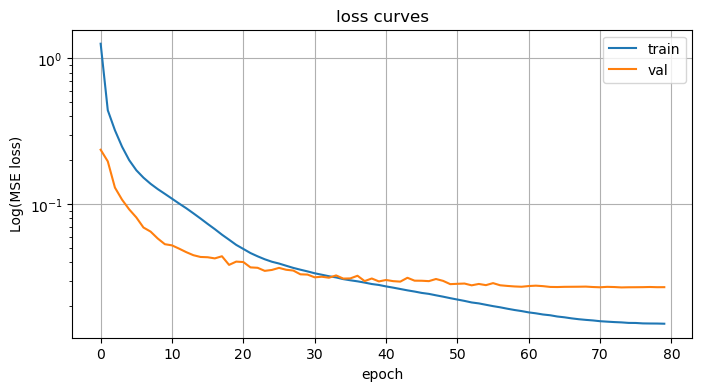

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(train_history, label="train")
plt.plot(val_history,   label="val")
plt.xlabel("epoch");  plt.ylabel("Log(MSE loss)");  plt.yscale("log")
plt.title("loss curves");  plt.legend();  plt.grid(True);  plt.show()

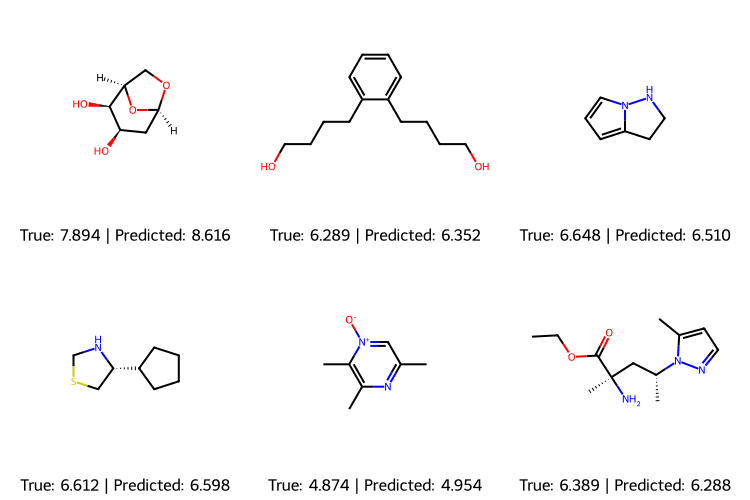

In [20]:
import random, torch
from rdkit import Chem
from rdkit.Chem import Draw
from ogb.lsc import PCQM4Mv2Dataset          

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for batch in valid_loader:          
        batch = batch.to(device, non_blocking=True)
        out   = model(batch)
        all_preds.append(out.cpu())
        all_targets.append(batch.y.view(-1,1).cpu())

all_preds = torch.cat(all_preds).numpy().flatten()   
all_targets = torch.cat(all_targets).numpy().flatten()

# load SMILES for the same indices
smiles_ds = PCQM4Mv2Dataset(root="C:/Users/mattg/Downloads/HOMO-LUMO/data/pcqm4mv2", only_smiles=True)

assert max(valid_ids) < len(smiles_ds), "idx out of range - check dataset root"

valid_smiles = [smiles_ds[i] for i in valid_ids]       # list of (smiles, y)

k = 6
r_idx = random.sample(range(len(valid_ids)), k=k)

smiles = [ valid_smiles[i][0] for i in r_idx]
y_true = [ valid_smiles[i][1] for i in r_idx]
y_pred = [ all_preds[i] for i in r_idx]
mols = [Chem.MolFromSmiles(s) for s in smiles]

legends = [f"True: {t:.3f} | Predicted: {p:.3f}" for t, p in zip(y_true, y_pred)]
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(250, 250), legends=legends, useSVG=True)

img

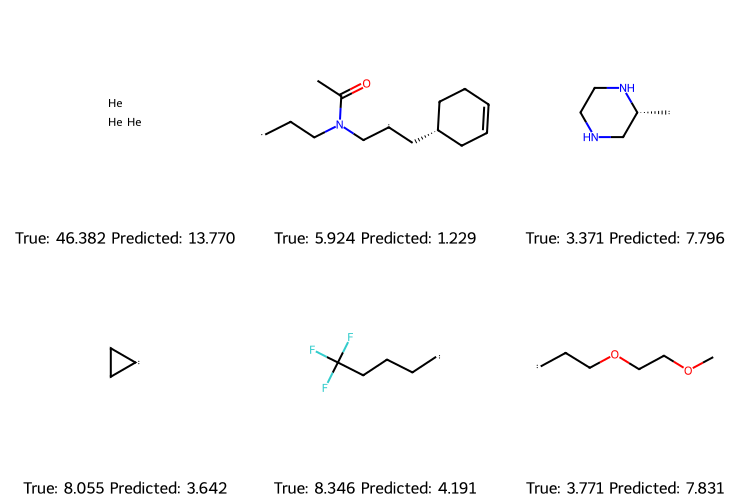

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# inference on the validation subset 
val_preds = []
val_targets = []
orig_ids= []               

with torch.no_grad():
    for batch_idx, batch in enumerate(valid_loader):
        batch = batch.to(device, non_blocking=True)
        pred = model(batch).cpu().numpy().flatten()
        val_preds.append(pred)
        val_targets.append(batch.y.view(-1).cpu().numpy())
        first   = batch_idx * valid_loader.batch_size
        count   = pred.shape[0]
        orig_ids.extend(valid_ids[first:first+count])

val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

sm_data = PCQM4Mv2Dataset(root="C:/Users/mattg/Downloads/HOMO-LUMO/data/pcqm4mv2", only_smiles=True)

valid_smiles = [sm_data[i] for i in orig_ids]  

errors  = np.abs(val_preds - val_targets)
top_k   = errors.argsort()[-6:][::-1]

smiles  = [valid_smiles[i][0] for i in top_k]
y_true  = val_targets[top_k]
y_pred  = val_preds[top_k]

mols    = [Chem.MolFromSmiles(s) for s in smiles]
labels  = [f"True: {t:.3f} Predicted: {p:.3f}" for t, p in zip(y_true, y_pred)]

img = Draw.MolsToGridImage(mols, legends=labels, molsPerRow=3, subImgSize=(250,250), useSVG=True)
img

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg = dict(gnn_dim = 512,
           hidden_dim = 256,
           extra_atom_dim = 5,
           rdkit_dim = 6,
           dropout = 0.2142,
           act = "GELU",
           # optimiser / schedule
           max_lr = 8e-5, # ⅓ of valley bottom
           div_factor = 25, # init_lr 3.2e-6
           final_div_factor = 5_000, # min_lr 1.6e-8
           pct_start = 0.30,
           weight_decay = 2e-5,
           num_epochs = 80,
           # misc
           accum_steps = 1,
           clip_norm = 2.0,
           patience = 10)

model = GNN_Transformer_Hybrid(gnn_dim = cfg["gnn_dim"],
                               rdkit_dim = cfg["rdkit_dim"],
                               hidden_dim = cfg["hidden_dim"],
                               extra_atom_dim = cfg["extra_atom_dim"],
                               dropout_rate = cfg["dropout"],
                               activation = cfg["act"]).to(device)

In [ ]:
from torch_geometric.loader import DataLoader
from ogb.lsc import PCQM4Mv2Dataset
import numpy as np, pandas as pd, torch
from tqdm import tqdm
from build_pcqm4m_lmdb import SAVE_DIR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load("best_gnn_transformer_hybrid.pt"))
model.to(device).eval()

smiles_ds = PCQM4Mv2Dataset(root=f"{DATA_ROOT}/pcqm4mv2/pcqm4m-v2/", only_smiles=True)
split     = smiles_ds.get_idx_split()
test_ids  = split['test-dev']            

TEST_LMDB = os.path.join(SAVE_DIR, "pcqm4m_test-dev3d_dist.lmdb")
test_loader = DataLoader(LMDBDataset(test_ids, TEST_LMDB), batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

# inference 
all_preds, all_idx = [], []
with torch.no_grad():
    for first, batch in tqdm(enumerate(test_loader), total=len(test_loader), desc="predict"):
        batch = batch.to(device, non_blocking=True)
        pred  = model(batch).cpu().numpy().ravel()

        all_preds.append(pred)
        # the slice of indices that produced this batch
        start = first * test_loader.batch_size
        all_idx.append(test_ids[start:start + len(pred)])

all_preds = np.concatenate(all_preds)
all_idx = np.concatenate(all_idx)
assert len(all_preds) == len(all_idx)

pd.DataFrame({"mol_index": all_idx, "prediction": all_preds}).to_csv("hybridgnn_testdev_predictions.csv", index=False)

print("saved hybridgnn_testdev_predictions.csv" f"(n={len(all_preds):,})")

c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\ogb\lsc\pcqm4mv2_pyg.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self

2-D graphs loaded & RDKit features attached


[00:26:20] Warning: molecule is tagged as 3D, but all Z coords are zero
[00:29:41] WARNING: not removing hydrogen atom without neighbors
[00:29:41] WARNING: not removing hydrogen atom without neighbors
[00:29:41] WARNING: not removing hydrogen atom without neighbors
[00:29:47] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[00:29:47] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[00:29:47] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[00:29:47] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[00:29:47] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[00:29:47] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[00:29:50] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[00:29:50] WARNING:

usable train conformers: 3,378,606
LMDB already exists - set REBUILD=True to force rebuild


C:\Users\mattg\AppData\Local\Temp\ipykernel_25204\1840175667.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_gnn_transformer_hybri

saved hybridgnn_testdev_predictions.csv(n=147,037)


1 Find the missing validation graphs

In [6]:
import lmdb, os, tqdm, numpy as np
from ogb.lsc import PCQM4Mv2Dataset
from graphdata_lmdb import LMDBDataset          # your wrapper

DATA_ROOT = r"C:/Users/mattg/Downloads/HOMO-LUMO/data"
SAVE_DIR  = f"{DATA_ROOT}/processed_chunks"
TRAIN_LMDB = os.path.join(SAVE_DIR, "pcqm4m_train3d_dist.lmdb")

# authoritative split
smiles_ds  = PCQM4Mv2Dataset(root=f"{DATA_ROOT}/pcqm4mv2/pcqm4m-v2/", only_smiles=True)
valid_ids  = set(smiles_ds.get_idx_split()['valid'])

# open existing LMDB in RO mode and collect every stored key
env = lmdb.open(TRAIN_LMDB, readonly=True, lock=False)
with env.begin() as txn:
    present_ids = {int(k.decode()) for k,_ in txn.cursor()}

missing_ids = sorted(valid_ids - present_ids)
print(f"Total valid molecules : {len(valid_ids):,}")
print(f"Already in LMDB       : {len(present_ids & valid_ids):,}")
print(f"**Missing in LMDB**   : {len(missing_ids):,}")


c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\ogb\lsc\pcqm4mv2.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  split_dict = torch.load(osp.join(self.folde

Total valid molecules : 73,545
Already in LMDB       : 0
**Missing in LMDB**   : 73,545


 Make a separate “valid-only” LMDB

In [6]:
import os, torch, numpy as np
from torch_geometric.loader import DataLoader
from ogb.lsc import PCQM4Mv2Dataset, PCQM4Mv2Evaluator
from graphdata_lmdb import LMDBDataset        
from build_pcqm4m_lmdb import MAX_NODES        

DATA_ROOT = r"C:/Users/mattg/Downloads/HOMO-LUMO/data"
SAVE_DIR  = f"{DATA_ROOT}/processed_chunks"

TRAIN_LMDB = os.path.join(SAVE_DIR, "pcqm4m_train3d_dist.lmdb")
TEST_LMDB  = os.path.join(SAVE_DIR, "pcqm4m_test-dev3d_dist.lmdb")  
VALID_LMDB = os.path.join(SAVE_DIR, "pcqm4m_valid3d_dist.lmdb")
# — load model weights —
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GNN_Transformer_Hybrid(gnn_dim = 512,
                               hidden_dim = 256,
                               rdkit_dim = 6,
                               extra_atom_dim = 5,
                               dropout_rate = 0.2142,
                               activation = "GELU").to(device)

model.load_state_dict(torch.load("best_gnn_transformer_hybrid.pt", map_location=device))
model.eval()

c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\ogb\lsc\pcqm4mv2_pyg.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self

2-D graphs loaded & RDKit features attached


[18:26:57] Warning: molecule is tagged as 3D, but all Z coords are zero
[18:30:16] WARNING: not removing hydrogen atom without neighbors
[18:30:16] WARNING: not removing hydrogen atom without neighbors
[18:30:16] WARNING: not removing hydrogen atom without neighbors
[18:30:22] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[18:30:22] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[18:30:22] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[18:30:22] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[18:30:22] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[18:30:22] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[18:30:25] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[18:30:25] WARNING:

usable train conformers: 3,378,606
LMDB already exists - set REBUILD=True to force rebuild


C:\Users\mattg\AppData\Local\Temp\ipykernel_12736\1626944190.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_gnn_transformer_hybr

GNN_Transformer_Hybrid(
  (atom_encoder): ExtendedAtomEncoder(
    (atom_encoder): AtomEncoder(
      (atom_embedding_list): ModuleList(
        (0): Embedding(119, 512)
        (1): Embedding(5, 512)
        (2-3): 2 x Embedding(12, 512)
        (4): Embedding(10, 512)
        (5-6): 2 x Embedding(6, 512)
        (7-8): 2 x Embedding(2, 512)
      )
    )
    (extra_proj): Linear(in_features=5, out_features=512, bias=True)
    (output_proj): Linear(in_features=1024, out_features=512, bias=True)
  )
  (bond_encoder): BondEncoderWithDist(
    (cat_enc): BondEncoder(
      (bond_embedding_list): ModuleList(
        (0): Embedding(5, 512)
        (1): Embedding(6, 512)
        (2): Embedding(2, 512)
      )
    )
    (dist_mlp): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (conv1): GINEConv(nn=Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)


In [7]:
def pretty_param_count(m):
    return f"{sum(p.numel() for p in m.parameters()):,}"

print("{:<35s} {:>15s}".format("module", "# params"))
print("-"*52)
for name, sub in model.named_children():
    print(f"{name:<35s} {pretty_param_count(sub):>15s}")
print("-"*52)
print(f"{'TOTAL':<35s} {pretty_param_count(model):>15s}")

module                                     # params
----------------------------------------------------
atom_encoder                                616,960
bond_encoder                                286,208
conv1                                       525,312
edge_upd1                                 1,049,600
conv2                                       525,312
edge_upd2                                 1,049,600
triplet                                     263,680
transformer                               6,305,792
mlp                                         165,889
----------------------------------------------------
TOTAL                                    10,788,865


In [8]:
# split indices (authoritative) 
smiles_ds   = PCQM4Mv2Dataset(root=f"{DATA_ROOT}/pcqm4mv2/pcqm4m-v2/", only_smiles=True)
split_idx   = smiles_ds.get_idx_split()
valid_ids   = split_idx['valid']      
testdev_ids = split_idx['test-dev']   

c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\ogb\lsc\pcqm4mv2.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  split_dict = torch.load(osp.join(self.folde

In [9]:
# DataLoader over validation indices 
valid_loader = DataLoader(LMDBDataset(valid_ids, VALID_LMDB), batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

# inference 
y_pred, y_true = [], []
with torch.no_grad():
    for batch in valid_loader:
        batch = batch.to(device, non_blocking=True)
        out   = model(batch).view(-1).cpu()
        y_pred.append(out)
        y_true.append(batch.y.view(-1).cpu())

y_pred = torch.cat(y_pred) # 1-D tensor (num_valid,)
y_true = torch.cat(y_true)

print("Shapes:", y_pred.shape, y_true.shape)

# official metric 
evaluator  = PCQM4Mv2Evaluator()
mae = evaluator.eval({'y_pred': y_pred, 'y_true': y_true})['mae']
print(f"Official validation MAE: {mae:.5f}")

Error: C:/Users/mattg/Downloads/HOMO-LUMO/data/processed_chunks\pcqm4m_valid3d_dist.lmdb: The system cannot find the path specified.


In [11]:
# DataLoader over test-dev indices 
test_loader = DataLoader(LMDBDataset(testdev_ids, TEST_LMDB), batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

preds = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device, non_blocking=True)
        preds.append(model(batch).view(-1).cpu())

y_pred_test = torch.cat(preds) # (num_test-dev,)
assert y_pred_test.numel() == len(testdev_ids)

#  save in the required .npz format 
evaluator.save_test_submission(
        input_dict = {'y_pred': y_pred_test},
        dir_path   = "submission_dir", # any empty / new folder
        mode       = 'test-dev')

print("saved submission_dir/y_pred_pcqm4m-v2_test-dev.npz")

saved submission_dir/y_pred_pcqm4m-v2_test-dev.npz
